# 0.0 Imports

In [228]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import datetime as dt
import re
import warnings

from IPython.display import Image
from IPython.core.display import HTML
warnings.filterwarnings('ignore')

## 0.2 Loading Data

In [2]:
df = pd.read_csv('../data/raw/Ecommerce.csv')
df.drop('Unnamed: 8', axis=1,inplace=True)

# 1.0 Data Description

In [3]:
df1 = df.copy()

* Invoice Number: identificador único de cada transação.
* Stock Code Product: código do item.
* Description Product: nome do item
* Quantity: A quantidade de cada item comprado por transação.
* Invoice Date: O dia em que a transação ocorreu
* Unit Price: Preço do produto por unidade
* Customer ID: identificador único do cliente
* Country: O nome do país que o cliente resid

In [4]:
df1.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice  CustomerID         Country  
0   29-Nov-16       2.55     17850.0  United Kingdom  
1   29-Nov-16       3.39     17850.0  United Kingdom  
2   29-Nov-16       2.75     17850.0  United Kingdom  
3   29-Nov-16       3.39     17850.0  United Kingdom  
4   29-Nov-16       3.39     17850.0  United Kingdom

## 1.1 Rename Columns

In [5]:
old_cols = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase,old_cols))

# Rename columns
df1.columns = new_cols

## 1.2 Data Dimension

In [6]:
print('Number of row: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of row: 541909
Number of columns: 8


## 1.3 Data Types

In [7]:
df1.dtypes 

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Changing Data Types

Converting `invoice_date` from object to datetime.

In [8]:
df1.invoice_date = pd.to_datetime(df1.invoice_date)

Converting `customer_id` from float to string, preserving the null values.

In [9]:
df1.customer_id[df1.customer_id.notnull()] = df1.customer_id[df1.customer_id.notnull()].astype(str)
df1.customer_id.dtypes

dtype('O')

## 1.5 Null Values

In [10]:
df1.isna().sum()[df1.isna().sum()>0]

description      1454
customer_id    135080
dtype: int64

In [11]:
# Percent of NAs in customer_id
df1.customer_id.isna().sum()/df.shape[0]

0.249266943342886

As we can see, customer_id has almost 25% of its observation as null values. This implicates in more diffifulty in terms of creating the Insiders lists of customers. Some doubts arrise: can we assume that each NA is an single different customer? Do they repeat? How to input these values?

We may figure this out analysing `customer_id` unique values furthermore. 

## 1.6 Descriptive statistics

In [12]:
# Number of unique customers
df1.customer_id.nunique() 

4372

In [13]:
# Amount of transaction with a known customer
t = df1.shape[0]-135080 # Nº of customer_id NAs
# Average of transactions per customer
print(t/4372)

93.05329368709972


### 1.6 Numerical Variable

In [14]:
df1[['quantity', 'unit_price']].describe()

quantity     unit_price
count  541909.000000  541909.000000
mean        9.552250       4.611114
std       218.081158      96.759853
min    -80995.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   38970.000000

The presence of negative values corresponds to products' return and chargeback. This can be seen by the example above where there is the exact same value of `quantity` for both max and min and their signs opposition. Other interesting point to express is prevalence of small quantities in the transations and small price per unit: 75% of the transaction have up to 10 product units and cost up to $4.13.

In [15]:
# All return and chargeback transaction
df1[(df1['quantity'] < 0) | (df1['unit_price']<0)]

invoice_no stock_code                       description  quantity  \
141       C536379          D                          Discount        -1   
154       C536383     35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235       C536391      22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236       C536391      21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237       C536391      21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   
...           ...        ...                               ...       ...   
540449    C581490      23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
541541    C581499          M                            Manual        -1   
541715    C581568      21258        VICTORIAN SEWING BOX LARGE        -5   
541716    C581569      84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
541717    C581569      20979     36 PENCILS TUBE RED RETROSPOT        -5   

       invoice_date  unit_price customer_id         country  
141      2016-11-29       27.50     14527.0  United Kingdom  
154      2016-11-29        4.65     15311.0  United Kingdom  
235      2016-11-29        1.65     17548.0  United Kingdom  
236      2016-11-29        0.29     17548.0  United Kingdom  
237      2016-11-29        0.29     17548.0  United Kingdom  
...             ...         ...         ...             ...  
540449   2017-12-07        0.83     14397.0  United Kingdom  
541541   2017-12-07      224.69     15498.0  United Kingdom  
541715   2017-12-07       10.95     15311.0  United Kingdom  
541716   2017-12-07        1.25     17315.0  United Kingdom  
541717   2017-12-07        1.25     17315.0  United Kingdom  

[10626 rows x 8 columns]

In [16]:
# Percent of chargeback transactions
(df1[(df1['quantity'] < 0) | (df1['unit_price']<0)].shape[0]/df1.shape[0]) * 100

1.9608458246679794

**The presence of chargeback transaction is insignificant as it represents only 1.96% of all transactions.** This is important for the building of the bussiness notion around the fidelity prorgram criterias.

# 2.0 Feature Engeneering

In [17]:
df2 =df1.copy()

## 2.1 Hypothesis Mind Map

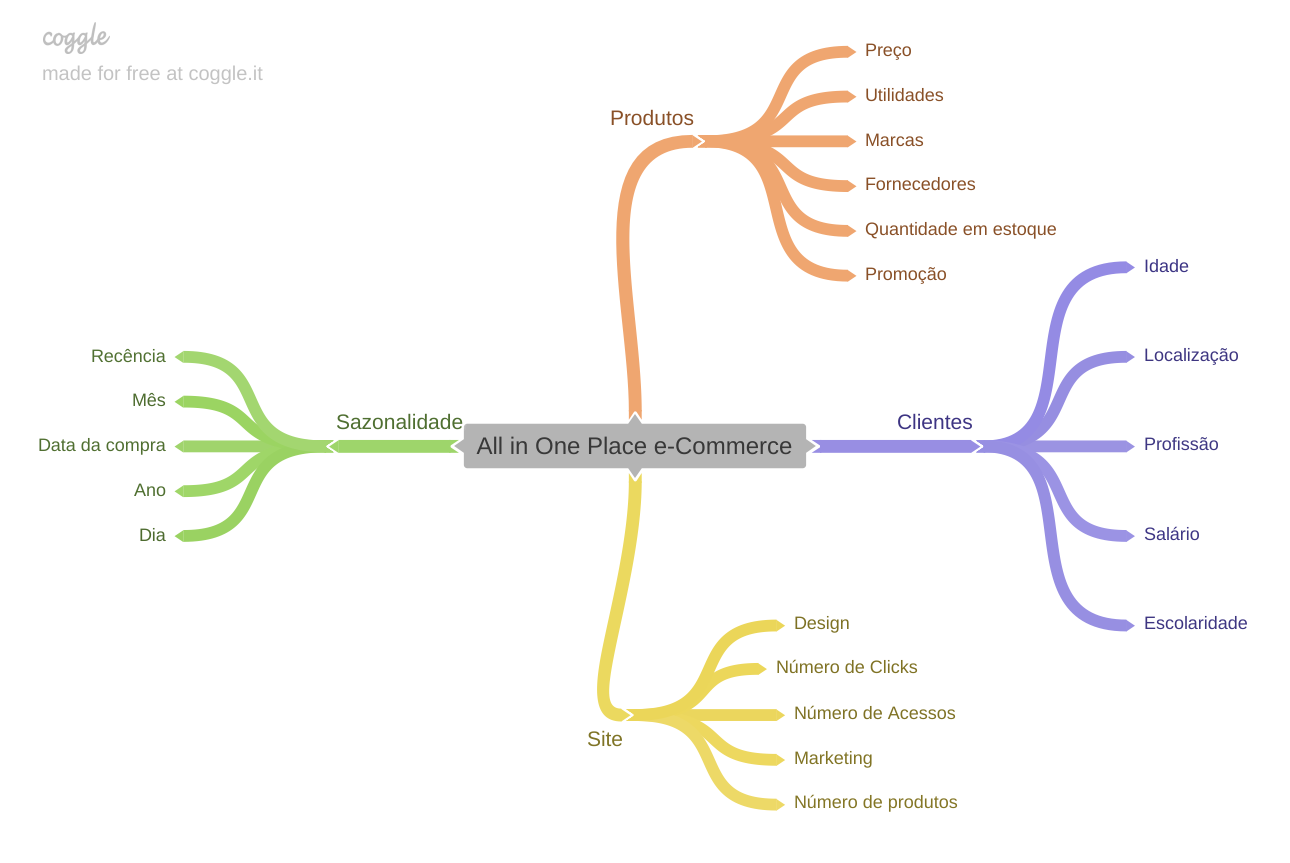

In [18]:
Image('../reports/figures/mindmap.png')

## 2.2 Hypothesis Creation

### 2.2.1 Clientes
1. **Clientes que moram em países europeus compram mais?**
2. Clientes com maior escolaridade compram mais?
3. Clientes mais jovens compram mais?
4. Clientes com maior salário compram mais? 

### 2.2.2. Produtos
1. **Produtos com preços menores vendem mais**
2. Produtos em promoção vendem mais
3. Produtos em maior quantidade no estoque vendem mais
4. Produtos de marcas mais conhecidas vendem mais
5. Produtos com maior número de fornecedores vendem menos
6. Protudos de utilidade mais rotineira vendem mais

### 2.2.3 Site
1. Maior número de acesso no site é acompanhado com aumento das vendas
2. Produtos com maior visibilidade no site vendem mais
3. Produtos com mais clicks vendem mais.
4. Produtos com marketing direcionado vendem mais

### 2.2.4 Sazonalidade
1. **As vendas aumentam no final do ano**
2. **As pessoas compram mais no início do mês(Até dia 10)**



### 2.2.5 Lista Final de Hipóteses (baseada na disponibilidade de dados)
1. Clientes que moram em países europeus compram mais?
2. Produtos com preços menores vendem mais
3. As vendas aumentam no final do ano
4.As pessoas compram mais no início do mês(Até dia 10)

# 2.3 Brainstorm questions

### 2.3.1 Clientes
1. Quais países compram mais?
2. Quais países compram menor?
2. Média de quantidade de compras por cliente
2. Média de preço de compra por cliente
3. Quantos clientes compram mais?
4. Quantos clientes compram menos?
5. Quantos clientes pedem estorno?


### 2.3.2 Produtos
1. Quantos produtos diferentes existem?
2. Quais produtos mais vendidos?
3. Quais produtos menos vendidos?
4. Quais produtos mais caros?
5. Quais produtos mais baratos?
6. Quais produtos mais comprados por cada país?
7. Quais produtos mais estornados?
8. Qual a média do preço dos produtos estornados?
9. Qual valor total estornado?


### 2.3.3 Tempo
1. Quais meses vendem mais?
2. Quais meses vendem menos?
3. Qual a recência (o intervalo desde a última compra) de cada cliente?
4. Quantos clientes compram com mais frequência? Qual a porcentagem da base de clientes?
5. Qual a frequência de estorno de produtos?


# 3.0 Feature Engeneering 

In [19]:
df3 = df2.copy()

## 3.1 Feature Creation

* Time Variables

In [20]:
# Year
df3['year'] = df3.invoice_date.dt.year
# Month
df3['month'] = df3.invoice_date.dt.month
# Day
df3['day'] = df3.invoice_date.dt.day


# 3.2 Searching Invoice Number and Stock Code

In [21]:
# All invoice numbers that incluide a letter
invoice_code = df3[df3['invoice_no'].str.contains("[A-Z]")]
invoice_code.head()

invoice_no stock_code                       description  quantity  \
141    C536379          D                          Discount        -1   
154    C536383     35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235    C536391      22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236    C536391      21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237    C536391      21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

    invoice_date  unit_price customer_id         country  year  month  day  
141   2016-11-29       27.50     14527.0  United Kingdom  2016     11   29  
154   2016-11-29        4.65     15311.0  United Kingdom  2016     11   29  
235   2016-11-29        1.65     17548.0  United Kingdom  2016     11   29  
236   2016-11-29        0.29     17548.0  United Kingdom  2016     11   29  
237   2016-11-29        0.29     17548.0  United Kingdom  2016     11   29

In [22]:
print(invoice_code.shape[0])
print(invoice_code.invoice_no.nunique())
print(invoice_code.shape[0]/invoice_code.invoice_no.nunique())

9291
3839
2.420161500390727


From all 9291 invoice numbers that include a letter (or a code), 3839 are unique. This means that, in average, every transaction classified as a chargeback (the reason why it has the letter "C") included almost 3 products.

In [23]:
letters = invoice_code.invoice_no.str[0]
letters.unique()

array(['C', 'A'], dtype=object)

In [24]:
invoice_code[invoice_code.invoice_no.str[0] == "A"]

invoice_no stock_code      description  quantity invoice_date  \
299982    A563185          B  Adjust bad debt         1   2017-08-10   
299983    A563186          B  Adjust bad debt         1   2017-08-10   
299984    A563187          B  Adjust bad debt         1   2017-08-10   

        unit_price customer_id         country  year  month  day  
299982    11062.06         NaN  United Kingdom  2017      8   10  
299983   -11062.06         NaN  United Kingdom  2017      8   10  
299984   -11062.06         NaN  United Kingdom  2017      8   10

Besides the chargeback, the letter "A" also appears and it stands for "Adjust bad debt".

We also have different "types" of chargebacks, what can be seen by the different stock codes below.

In [25]:
df3[df3.stock_code.str.len() ==1].stock_code.unique()

array(['D', 'M', 'S', 'm', 'B'], dtype=object)

By now, we'll create a variable to determine if the transaction is normal, is a chargeback ou an adjust bad debt.

In [26]:
# Creating transaction type variable
new_col = []
for string in df3.invoice_no:
    if string[0] == "C":
        new_col.append('chargeback')
    elif string[0] == "A":
        new_col.append('adjust_bad_debt')
    else:
        new_col.append('normal')
df3['transaction_type'] = pd.Series(new_col)

In [27]:
df3.transaction_type.value_counts()

normal             532618
chargeback           9288
adjust_bad_debt         3
Name: transaction_type, dtype: int64

* To improve: manage to create a variable column with conditional list comprehesion and/or with `apply` function + lambda

**In the next Crisp cycles, we might make use of variable filtering and columns selection, depending in the machine learning performance.**

# 4.0 Exploratory Data Analysis

In [28]:
df4 = df3.copy()

In [29]:
num = df4.select_dtypes(['int64','float64'])
cat = df4.select_dtypes('object')

### 2.3.1 Clientes
1. Quais países compram mais?
2. Quais países compram menor?
3. Média de quantidade de compras por cliente
4. Média de preço de compra por cliente
5. Quantos clientes compram mais?
6. Quantos clientes pedem estorno?


### 2.3.2 Produtos
1. Quantos produtos diferentes existem?
2. Quais produtos mais vendidos?
3. Quais produtos menos vendidos?
4. Quais produtos mais caros?
5. Quais produtos mais baratos?
6. Quais produtos mais comprados por cada país?
7. Quais produtos mais estornados?
8. Qual a média do preço dos produtos estornados?
9. Qual valor total estornado?


### 2.3.3 Tempo
1. Quais meses vendem mais?
2. Quais meses vendem menos?
3. Qual a recência (o intervalo desde a última compra) de cada cliente?
4. Quantos clientes compram com mais frequência? Qual a porcentagem da base de clientes?
5. Qual a frequência de estorno de produtos?

## 4.1 Univariate analysis

### 4.1.1 Categorical Variables

In [30]:
print('Number of different transactions:', cat.invoice_no.nunique())

Number of different transactions: 25900


In [31]:
# 1. Quantos produtos diferentes existem?
print('There are {} different product'.format(cat.description.nunique()))

There are 4223 different product


However, it is important to notice that some different products have the same stock code which can be deducted from the hight number of production descriptions in comparison with the stock codes. See below:

In [32]:
print('There are {} different stock codes'.format(cat.stock_code.nunique()))

There are 4070 different stock codes


In [33]:
# How many different countries buy from the e-commerce?
print('Products were bought from {} different contries'.format(cat.country.nunique()))

Products were bought from 38 different contries


In [34]:
print('{} different customers have bought from the e-commerce, not couting the undentified ones (NAs).'.format(cat.customer_id.nunique()))

4372 different customers have bought from the e-commerce, not couting the undentified ones (NAs).


### 4.1.2 Numerical Variables

As we have seen in the data description, units prices have strong outliers as 75% of all products cost up to 10 dollars, which can be observed below.

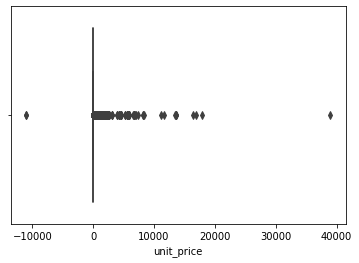

In [35]:
sns.boxplot(x='unit_price', data=num);

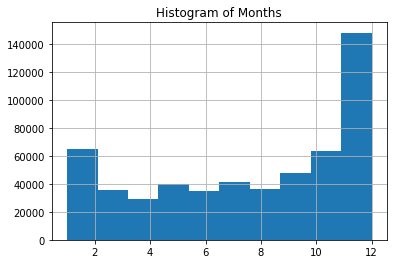

In [36]:
# Quais meses vendem mais? e quais vendem menos?
num['month'].hist();
plt.title('Histogram of Months');

By the histrogram above, it is possible to conclude that in the end of the year and beginning of the following year,notably **December** and **January** are the months with more purchases. Likewise March is the month with the fewest sells.

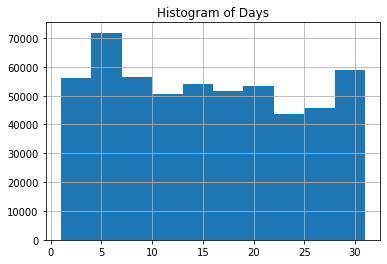

In [37]:
# Que dias do mês vendem mais e vendem menos?
num['day'].hist();
plt.title('Histogram of Days');

We can see that there is a decline trend in terms of customer purchase behavior. Sells tend to be higher at the begininng of the months, until around the seventh day. From this points onward, sales fall progressively until the end of the months.

## 4.2 Bivariate Analysis

Top 10 total quantity purchases per country

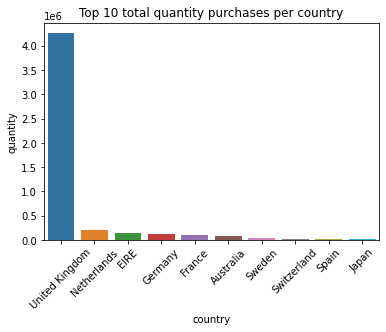

In [38]:
countries = df4[['country','quantity']].groupby('country').sum().reset_index().sort_values(by='quantity',ascending=False).head(10)
sns.barplot(x='country',y='quantity', data=countries).set_title('Top 10 total quantity purchases per country');
plt.xticks(rotation='45');

Majority of the client base comes from Europe, mainly United Kingdom, what impacts, for exemple, the marketing strategy to invest heavier in this country or to take a risker approuch to expand bussiness in other continents.

Top 10 clients with highest mean quantities per purchase

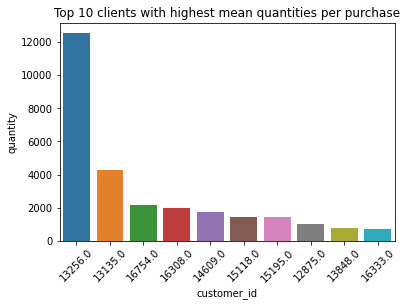

In [39]:
# Média de quantidade de compras por cliente
cust_10 = df4[['customer_id','quantity']].groupby('customer_id').mean().reset_index().sort_values(by='quantity',ascending=False).head(10)
sns.barplot(x='customer_id',y='quantity', data=cust_10).set_title('Top 10 clients with highest mean quantities per purchase')
plt.xticks(rotation='45');

Huge presence of outliers in the customers quantity

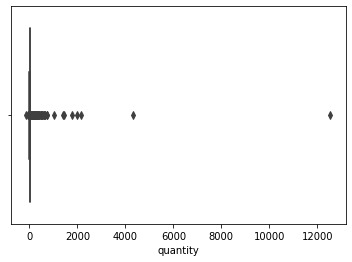

In [40]:
cust = df4[['customer_id','quantity']].groupby('customer_id').mean().reset_index()#.sort_values(by='quantity',ascending=False)
sns.boxplot(x=cust['quantity']);

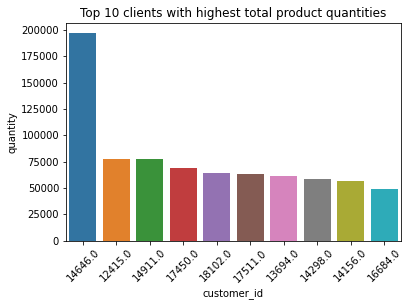

In [41]:
cust_sum = df4[['customer_id','quantity']].groupby('customer_id').sum().reset_index().sort_values(by='quantity',ascending=False).head(10)
sns.barplot(x='customer_id',y='quantity', data=cust_sum).set_title('Top 10 clients with highest total product quantities')
plt.xticks(rotation='45');

In [42]:
# Quais produtos mais vendidos?
df4.groupby('description')[['quantity']].sum().sort_values(by='quantity', ascending=False)

quantity
description                                
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53847
JUMBO BAG RED RETROSPOT               47363
ASSORTED COLOUR BIRD ORNAMENT         36381
POPCORN HOLDER                        36334
PACK OF 72 RETROSPOT CAKE CASES       36039
...                                     ...
Damaged                               -7540
Printing smudges/thrown away          -9058
check                                -12030
Unsaleable, destroyed.               -15644
printing smudges/thrown away         -19200

[4223 rows x 1 columns]

### 2.3.1 Clientes
1. Quais países compram mais?
2. Quais países compram menor?
3. Média de quantidade de compras por cliente
4. Média de preço de compra por cliente
5. Quantos clientes pedem estorno? Quantos produtos e qual valor total dos estornos?


### 2.3.2 Produtos
1. Quantos produtos diferentes existem?
2. Quais produtos mais vendidos?
3. Quais produtos menos vendidos?
4. Quais produtos com maior faturamento?
5. Quais produtos mais caros?
6. Quais produtos mais baratos?
7. Quais produtos mais comprados por cada país?
8. Quais produtos mais estornados?
9. Qual a média do preço dos produtos estornados?
10. Qual valor total estornado?


### 2.3.3 Tempo
1. Quais meses vendem mais?
2. Quais meses vendem menos?
3. Qual a recência (o intervalo desde a última compra) de cada cliente?
4. Quantos clientes compram com mais frequência? Qual a porcentagem da base de clientes?
5. Qual a frequência de estorno de produtos?

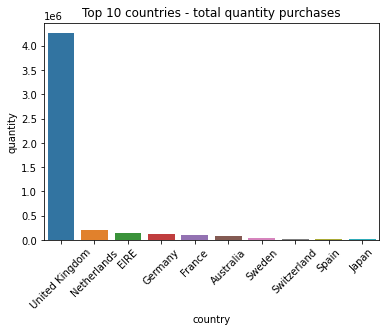

In [131]:
# 1. Quais países compram mais?
countries = df4[['country','quantity']].groupby('country').sum().reset_index().sort_values(by='quantity',ascending=False).head(10)
sns.barplot(x='country',y='quantity', data=countries).set_title('Top 10 countries - total quantity purchases');
plt.xticks(rotation='45');

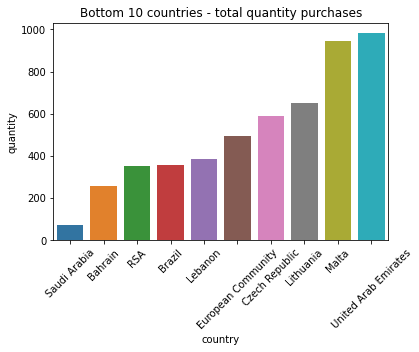

In [44]:
# # 2. Quais países compram menor?
# countries = df4[['country','quantity']].groupby('country').sum().reset_index().sort_values(by='quantity').head(10)
# sns.barplot(x='country',y='quantity', data=countries).set_title('Bottom 10 countries - total quantity purchases');
# plt.xticks(rotation='45');

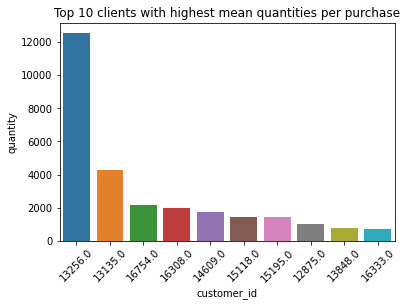

In [45]:
# 3. Média de quantidade de compras por cliente
cust_10 = df4[['customer_id','quantity']].groupby('customer_id').mean().reset_index().sort_values(by='quantity',ascending=False).head(10)
sns.barplot(x='customer_id',y='quantity', data=cust_10).set_title('Top 10 clients with highest mean quantities per purchase')
plt.xticks(rotation='45');

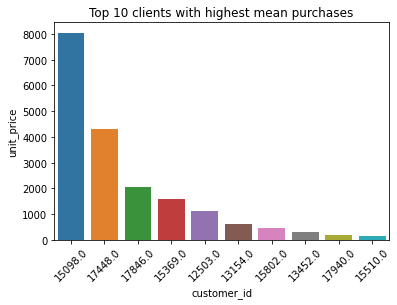

In [46]:
# 4. Média de preço de compra por cliente
cust_10 = df4[['customer_id','unit_price']].groupby('customer_id').mean().reset_index().sort_values(by='unit_price',ascending=False).head(10)
sns.barplot(x='customer_id',y='unit_price', data=cust_10).set_title('Top 10 clients with highest mean purchases')
plt.xticks(rotation='45');

It's noticible that there is also a Top 5 clients that have a total mean purchase above $1000. However, it is necessary to look broader and see if clusters of clients appear in like a Top 25 or top 50.

In [47]:
# 5. Quantos clientes pedem estorno? Quantos produtos e qual valor total dos estornos?
print(invoice_code.customer_id.nunique(),'customers requested chargeback')
invoice_code[['customer_id','quantity','unit_price']].groupby('customer_id').sum().sort_values(by='quantity').head(25)

1589 customers requested chargeback


quantity  unit_price
customer_id                      
16446.0        -80995        2.08
12346.0        -74215        1.04
15838.0         -9361       11.55
15749.0         -9014       15.80
16029.0         -8060    15388.75
12931.0         -4627       35.99
14607.0         -3768       71.03
14911.0         -3335     4874.94
17949.0         -2975      489.93
12901.0         -2160       19.09
15482.0         -2022      107.56
15769.0         -2012       34.07
16013.0         -1691       54.92
12748.0         -1538     2910.00
17511.0         -1537      385.80
16938.0         -1515        0.55
13694.0         -1509      272.62
18133.0         -1350        0.16
14533.0         -1242        5.67
12607.0         -1228      217.93
12908.0         -1200        0.84
16422.0         -1112      579.41
12454.0         -1006      109.23
14680.0         -1002      153.06
17450.0          -964     2176.77

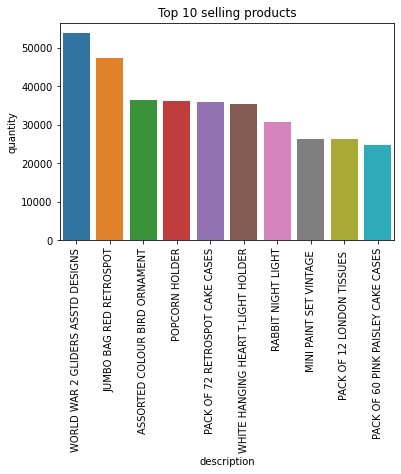

In [109]:
# 2. Quais produtos mais vendidos?

# create Dataframe orderd by total quantity sold
top_products = df4[['description','quantity']].groupby('description').sum().reset_index().sort_values(by='quantity', ascending=False)

sns.barplot(x='description',y='quantity', data=top_products.head(10)).set_title('Top 10 selling products');
plt.xticks(rotation='90');

In [ ]:
# 4. Quais produtos com maior faturamento?

# create a feauture with the mean price of each product
top_products['mean_price'] = top_products['description'].apply(lambda x:df4[df4['description']=='{}'.format(x)]['unit_price'].mean().round(2))
# create a feature of the total revenue of each product
top_products['product_revenue'] = top_products['quantity'] * top_products['mean_price']

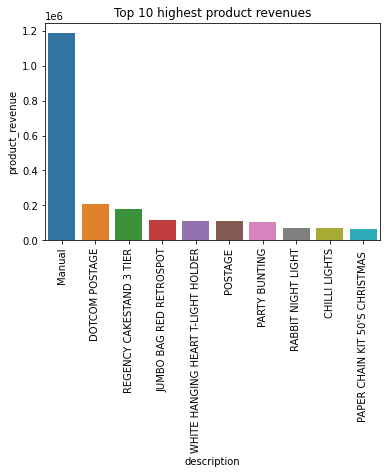

In [123]:
sns.barplot(x='description', y='product_revenue', data=top_products.sort_values(by='product_revenue', ascending=False).head(10)).set_title('Top 10 highest product revenues');
plt.xticks(rotation='90');

The difference between Manual's `product_revenue` compared to the rest of the product is too significant and deserve to be paid attention. What is Manual anyway?

In [ ]:
# boxplot quantity X product_revenue

In [199]:
top_products[top_products['quantity']>0].sort_values(by='mean_price', ascending=False).head(10)

description  quantity  mean_price  \
2521       PICNIC BASKET WICKER 60 PIECES        61      649.50   
2246                               Manual      3165      374.91   
1098                       DOTCOM POSTAGE       707      290.91   
2917         REGENCY MIRROR WITH SHUTTERS        10      156.43   
3034   RUSTIC  SEVENTEEN DRAWER SIDEBOARD        32      156.03   
3818          VINTAGE RED KITCHEN CABINET        50      150.66   
3768         VINTAGE BLUE KITCHEN CABINET        20      143.65   
740         CHEST NATURAL WOOD 20 DRAWERS        24      118.08   
2043        LOVE SEAT ANTIQUE WHITE METAL        54      115.39   
1133  Dotcomgiftshop Gift Voucher �100.00         1       83.33   

      product_revenue  
2521         39619.50  
2246       1186590.15  
1098        205673.37  
2917          1564.30  
3034          4992.96  
3818          7533.00  
3768          2873.00  
740           2833.92  
2043          6231.06  
1133            83.33

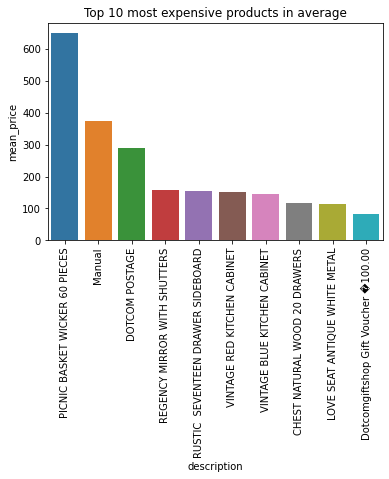

In [200]:
# 5. Quais produtos mais caros?
sns.barplot(x='description',y='mean_price', data=top_products[top_products['quantity']>0].sort_values(by='mean_price', ascending=False).head(10)).set_title('Top 10 most expensive products in average');
plt.xticks(rotation='90');

In [136]:
# 7. Quais produtos mais comprados por cada país?
top_quant_countries = df4[['country','description','quantity']].groupby(['country','description']).sum().reset_index()

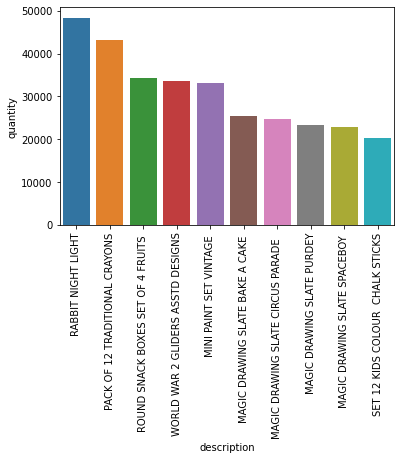

In [143]:
# for country in countries["country"].values:
#     sns.barplot(x='description', y='quantity',data=top_quant_countries[top_quant_countries['country']=='{}'.format(country)].sort_values(by='quantity',ascending=False).head(10));
#     plt.xticks(rotation='90');

In [145]:
# 8. Quais produtos mais estornados?
invoice_code.shape[0]

9291

Before we find out what are the most chargedback product, let's first check if our assumption works. We asssumed that all the chargeback transition had the invoice number beginning with the letter 'C', in a sort of 'code' as we created the dataframe `invoice_code`. The chargeback transactions are characterized by a negative value quatity. So lets check in the main dataframe if the number of transaction in ``invoice_code`` is the same for all negative value quantities in the main dataframe. To make it easier, we created the dataframe ``negative_quatity``.

In [177]:
negative_quantity = df4[df4['quantity']<0]

In [181]:
negative_quantity.shape[0] - invoice_code.shape[0]

1333

So there are 1333 more chargedback transitions than those with the `invoice_no` starting with 'C'.

In [184]:
more_chargeback = negative_quantity[~negative_quantity.invoice_no.index.isin(invoice_code.invoice_no.index)]
more_chargeback

invoice_no stock_code description  quantity invoice_date  unit_price  \
2406       536589      21777         NaN       -10   2016-11-29         0.0   
4347       536764     84952C         NaN       -38   2016-11-30         0.0   
7188       536996      22712         NaN       -20   2016-12-01         0.0   
7189       536997      22028         NaN       -20   2016-12-01         0.0   
7190       536998      85067         NaN        -6   2016-12-01         0.0   
...           ...        ...         ...       ...          ...         ...   
535333     581210      23395       check       -26   2017-12-05         0.0   
535335     581212      22578        lost     -1050   2017-12-05         0.0   
535336     581213      22576       check       -30   2017-12-05         0.0   
536908     581226      23090     missing      -338   2017-12-06         0.0   
538919     581422      23169     smashed      -235   2017-12-06         0.0   

       customer_id         country  year  month  day transaction_type  
2406           NaN  United Kingdom  2016     11   29           normal  
4347           NaN  United Kingdom  2016     11   30           normal  
7188           NaN  United Kingdom  2016     12    1           normal  
7189           NaN  United Kingdom  2016     12    1           normal  
7190           NaN  United Kingdom  2016     12    1           normal  
...            ...             ...   ...    ...  ...              ...  
535333         NaN  United Kingdom  2017     12    5           normal  
535335         NaN  United Kingdom  2017     12    5           normal  
535336         NaN  United Kingdom  2017     12    5           normal  
536908         NaN  United Kingdom  2017     12    6           normal  
538919         NaN  United Kingdom  2017     12    6           normal  

[1336 rows x 12 columns]

In [186]:
more_chargeback.description.unique()

array([nan, '?', 'check', 'damages', 'faulty', 'Dotcom sales',
       'reverse 21/5/10 adjustment', 'mouldy, thrown away.', 'counted',
       'Given away', 'Dotcom', 'label mix up', 'samples/damages',
       'thrown away', 'incorrectly made-thrown away.', 'showroom', 'MIA',
       'Dotcom set', 'wrongly sold as sets', 'Amazon sold sets',
       'dotcom sold sets', 'wrongly sold sets', '? sold as sets?',
       '?sold as sets?', 'Thrown away.', 'damages/display',
       'damaged stock', 'broken', 'throw away', 'wrong barcode (22467)',
       'wrong barcode', 'barcode problem', '?lost',
       "thrown away-can't sell.", "thrown away-can't sell", 'damages?',
       're dotcom quick fix.', "Dotcom sold in 6's", 'sold in set?',
       'cracked', 'sold as 22467', 'Damaged',
       'mystery! Only ever imported 1800',
       'MERCHANT CHANDLER CREDIT ERROR, STO', 'POSSIBLE DAMAGES OR LOST?',
       'damaged', 'DAMAGED', 'Display', 'Missing', 'wrong code?',
       'wrong code', 'adjust', 'crush

More surprisingly is that there are many product with damaged or mistaken condition, with no price and no customer identification.

Back to the question:

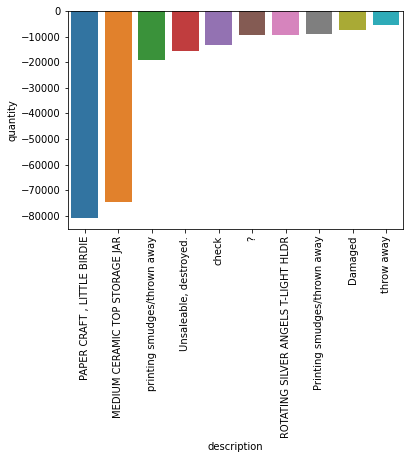

In [193]:
# 8. Quais produtos mais estornados?
sns.barplot(x='description', y='quantity', data=negative_quantity[['description','quantity']].groupby('description').sum().reset_index().sort_values(by='quantity').head(10));
plt.xticks(rotation='90');


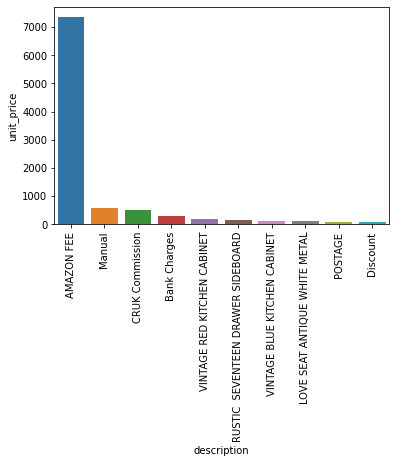

In [205]:
# 9. Qual a média do preço dos produtos estornados?
sns.barplot(x='description',y='unit_price',data=negative_quantity[['description','unit_price']].groupby('description').mean().reset_index().sort_values(by='unit_price',ascending=False).head(10));
plt.xticks(rotation='90');


In [213]:
# 10. Qual valor total estornado?
# negative_quantity[['description','unit_price','quantity']].groupby('description').sum().sort_values(by='unit_price',ascending=False).head(10)
print("The total chargebacks' value is ${}".format(negative_quantity.unit_price.sum()))

The total chargebacks' value is $449480.32


<AxesSubplot:xlabel='month', ylabel='unit_price'>

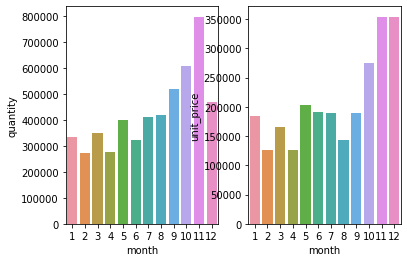

In [218]:
### 2.3.3 Tempo
# 1. Quais meses vendem mais?

# quantity
plt.subplot(1,2,1)
sns.barplot(x='month',y='quantity',data=df4[['month','quantity']].groupby('month').sum().reset_index())

# unit_price
plt.subplot(1,2,2)
sns.barplot(x='month',y='unit_price',data=df4[['month','unit_price']].groupby('month').sum().reset_index())

<AxesSubplot:xlabel='customer_id', ylabel='invoice_no'>

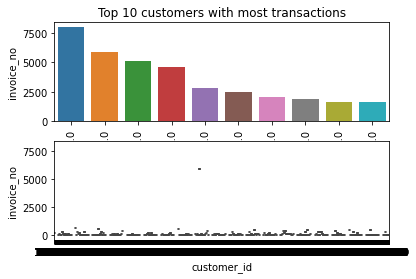

In [232]:
# 3. Qual a recência (o intervalo desde a última compra) de cada cliente?
# 4. Quantos clientes compram com mais frequência? Qual a porcentagem da base de clientes?
# No próximo ciclo, garantir que esse gráfico contenha apenas transacações que não seja estorno
plt.subplot(2,1,1)

sns.barplot(x='customer_id',y='invoice_no',data=df4[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index().sort_values(by='invoice_no',ascending=False).head(10));
plt.title('Top 10 customers with most transactions');
plt.xticks(rotation='90');

plt.subplot(2,1,2)
sns.boxplot(x='customer_id',y='invoice_no',data=df4[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index())

In [ ]:
# 5. Qual a frequência de estorno de produtos?